In [2]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # (미니) 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
#         print('x.shape',x.shape)                     # (128,28,28,1)
#         print('self.conv_w.shape',self.conv_w.shape) # (3,3,1,10)
#         print('self.conv_w',self.conv_w)
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
#         print('c_out.shape',c_out.shape)             # (128,28,28,10)
#         print('c_out',c_out)
        r_out = tf.nn.relu(c_out)
#         print('r_out.shape',r_out.shape)             # (128,28,28,10)
#         print('r_out',r_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
#         print('p_out.shape',p_out.shape)             # (128,14,14,10)
#         print('p_out',p_out)
        f_out = tf.reshape(p_out, [x.shape[0], -1])    # (128,1960)
#         print('f_out.shape',f_out.shape)
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
                                                     # (128,1960)(1960,100)+(100,)=(128,100)
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
                                                     # (128,100)(100,10)+(10,)=(128,10)
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels))) # filter의 수 10개 g() 좀 더 좋은 랜덤 초기화
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float) # filter의 수와 동일
        n_features = 14 * 14 * self.n_kernels #1960
        # 아래는 메모리 할당
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch) # x_batch.shape  (128, 28, 28, 1)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
 
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z) #전체 loss
            loss = tf.reduce_mean(loss) # 평균 loss

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [3]:
import tensorflow as tf
import numpy as np

x = tf.Variable(np.array([1.0, 2.0, 3.0]))
#x = np.array([1.0, 2.0, 3.0]) #tf객체여야만 아래 tf.GradientTape()로 값을 뽑을 수 있다
with tf.GradientTape() as tape:
    y = x ** 3 + 2 * x + 5
# 그래디언트를 계산합니다.
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [4]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:

print(x_train_all.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [7]:
print(x_train.shape)

(48000, 28, 28)


In [8]:

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [9]:

x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [10]:
print(x_train.shape)

(48000, 28, 28, 1)


In [11]:
x_train = x_train / 255
x_val = x_val / 255

In [12]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

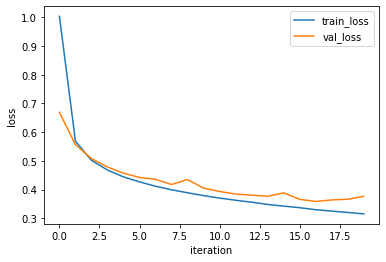

In [13]:

import matplotlib.pyplot as plt
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [14]:
cn.score(x_val, y_val_encoded)

0.8694166666666666

### 케라스로 합성곱 구하기

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1))) #10 = batch size, stride안적으면 1이다.
conv1.add(MaxPooling2D((2, 2)))
conv1.add(Flatten())
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [16]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', # adam SDG의 발전형태, categorical_crossentropy 다중분류일 때 손실함수, accuracy 정확도를 위한 history
              metrics=['accuracy'])

In [17]:

history = conv1.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.5784 - accuracy: 0.7987 - val_loss: 0.3178 - val_accuracy: 0.8897
Epoch 2/20
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3198 - accuracy: 0.8853 - val_loss: 0.3048 - val_accuracy: 0.8864
Epoch 3/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2576 - accuracy: 0.9058 - val_loss: 0.2596 - val_accuracy: 0.9058
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2256 - accuracy: 0.9172 - val_loss: 0.2744 - val_accuracy: 0.9004
Epoch 5/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1986 - accuracy: 0.9277 - val_loss: 0.2548 - val_accuracy: 0.9085
Epoch 6/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1758 - accuracy: 0.9375 - val_loss: 0.2427 - val_accuracy: 0.9157
Epoch 7/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1613 - accuracy: 0.9403 - val_loss: 0.2611 - val

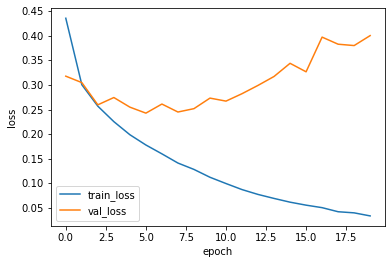

In [18]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

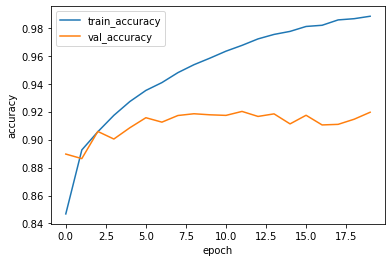

In [20]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

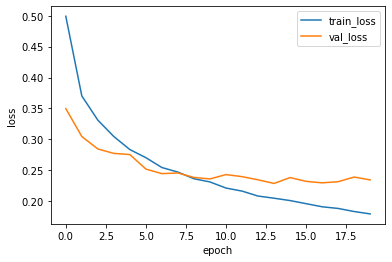

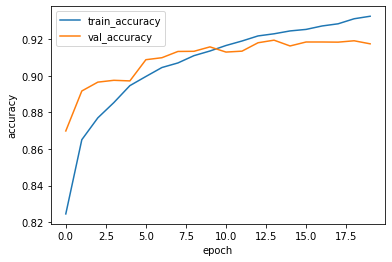

In [21]:

from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5)) # 50% drop out시킴. 20~50% 사이에서 해야 효과가 좋다
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))
conv2.summary()
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()